In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import gc
from sklearn.metrics import  roc_auc_score, average_precision_score

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language, rolling_mean, insert_needle

from src.attention_saver import Mistral7BAttentionSaver
from src.influence.influence import Influence, AttentionRollout

import scienceplots
plt.style.use(['science','no-latex'])

In [3]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tqdm.pandas()

df = load_dataset("stas/openwebtext-10k", cache_dir="/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))
df['context_length'] = df['text'].progress_apply(get_context_length, tokenizer = tokenizer)


chunks = []
for n in range (8):
    samples = df.query(f"context_length > {500*n} & context_length < {500*(n+1)}")\
        .sample(15, random_state = 43)
    
    chunks.append(samples)

# study_df = pd.concat(chunks)\
#     .sort_values("context_length", ascending = False)

indexes = [8263, 5418, 9572, 6251, 2927, 6800, 7716, 408, 4851, 8568, 6944,
       3651, 247, 703, 1176, 9336, 6207, 9683, 8572, 2193, 6571, 5087,
       4122, 4791, 8952, 1654, 3119, 9263, 6594, 9948, 3177, 1569, 1686,
       1726, 6939, 7577, 1799, 8927, 6281, 9942, 5392, 7620, 9842, 3979,
       6532, 5037, 8052, 2590, 8459, 1172, 6969, 2731, 5064, 3526, 6461,
       6565, 2537, 9679, 695, 2235, 8894, 7514, 2454, 1656, 7796, 9852,
       8200, 7016, 6692, 3507, 3001, 8227, 6280, 6537, 8620, 9484, 2028,
       5560, 5645, 412, 6559, 1497, 928, 7862, 6798, 6874, 4734, 2956,
       3601, 6201, 9017, 2673, 433, 4861, 5407, 9311, 6810, 9155, 2626,
       6219, 9301, 3564, 1413, 7146, 7169, 3749, 9734, 5389, 8266, 3224,
       1391, 9375, 697, 2319, 3099, 8065, 5834, 8867, 8841, 5378]

study_df = df.iloc[indexes]

100%|██████████| 10000/10000 [00:18<00:00, 539.89it/s]


## Adding the needle

In [5]:
needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "Your objective is to answer the following question based on the context: \nWhat is the best thing to do in San Francisco? \nDon't give information outside the document or repeat our findings"

In [6]:
all_df = []

instructions = [needle]

for instruction in instructions:
    for depth_percent in tqdm(range(0, 125, 25)):

        percent_df = study_df.apply(
            insert_needle, 
            depth_percent = depth_percent, 
            question = question,
            needle = instruction, 
            axis = 1
        )

        all_df.append(percent_df)




  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


In [7]:
samples_df = pd.concat(all_df)\
    .reset_index()

## Computing influence of the needle in the text

## Attention rollout

In [48]:
N_LAYERS = 32
attention_rollout_calculator = AttentionRollout(
    base_model,
    tokenizer,
    N_LAYERS
)
attention_rollout_results = attention_rollout_calculator(
    samples_df,
    0,
    use_values=False,
    instruction_in_text=True,
    instruction_col="needle",
    text_col="new_text",
)

272 299
Forward propagation on instruction = 
The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.
. Index = 599
Influence tokens : 272 to 299
Studying influence to '
The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.
'


Finished forward step in 0.3288540840148926 s


100%|██████████| 32/32 [00:00<00:00, 918.94it/s]

Passing tensors to CPU...


In [49]:
groupby_text_idx = {}
for (text_idx, instruction) in attention_rollout_results.keys():
    if not text_idx in groupby_text_idx:
        groupby_text_idx[text_idx] = {}

    if not instruction in groupby_text_idx[text_idx]:
        groupby_text_idx[text_idx][instruction] = {}

    for layer in [0, 15, 31]:
        groupby_text_idx[text_idx][instruction][layer] = attention_rollout_results\
            [(text_idx, instruction)]\
            ['influences']\
            [layer]

In [50]:
x= pd.DataFrame(groupby_text_idx)
x.index.name = 'depth'
melted_influences_rollout = pd.melt(
    x.reset_index(), 
    id_vars=['depth'],
    value_name = 'influence',
    var_name = 'text_idx'    
).dropna()

In [51]:
cols = samples_df.columns\
    .difference(melted_influences_rollout.columns)

melted_influences_rollout = pd.merge(
    melted_influences_rollout,
    samples_df[cols.union(['depth', 'index'])],
    left_on = ['text_idx', 'depth'],
    right_on = ['index', 'depth']
)

# melted_influences['context_length'] = melted_influences['influence'].apply(get_ctx_len)

In [53]:
melted_influences_rollout.to_pickle("data/influences/needle/influence_needle_rollout2.pkl")

In [14]:
# melted_influences_rollout.to_pickle("data/influences/needle/influence_needle_rollout.pkl")

In [8]:
melted_influences_rollout = pd.read_pickle("data/influences/needle/influence_needle_rollout2.pkl")

In [9]:
melted_influences_rollout['depth_bins'] = pd.cut(
    melted_influences_rollout['depth'],
    range(0,125,25),
    include_lowest = True
)

melted_influences_rollout['layer 31'] = melted_influences_rollout['influence']\
    .apply(lambda x: x[31])

def get_avg_tensors(x):
    a = x.to_list()
    for idx in range(len(a)):
        a[idx] = a[idx][-1:]

    return pd.Series(torch.stack(a).squeeze().numpy())

last_layer_influences = melted_influences_rollout.groupby('depth_bins')\
    ['layer 31']\
    .apply(get_avg_tensors)

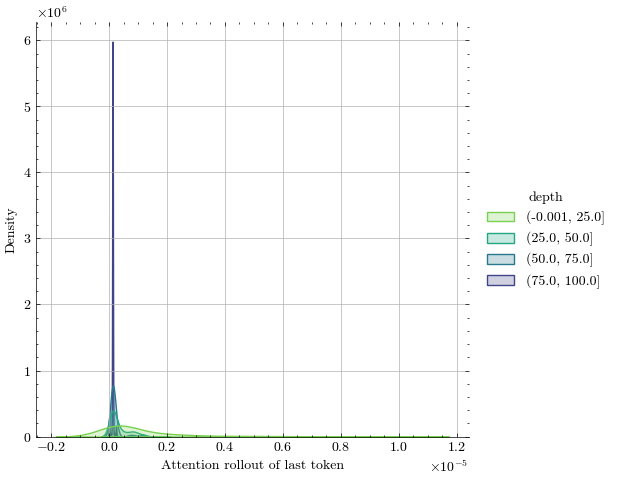

In [10]:
fig = sns.displot(
    last_layer_influences.reset_index(),
    x = 'layer 31',
    hue = 'depth_bins',
    kind = 'kde',
    fill = True,
    palette = 'viridis_r',
)

fig._legend.set_title("depth")

plt.xlabel("Attention rollout of last token")
plt.grid()

In [11]:
generated_texts = dict()
decoded = None

for idx, row in melted_influences_rollout.iterrows():
    text = row['new_text']
    text_idx = row['text_idx']
    depth = row['depth']

    message = [{"role": "user", "content": text}]
    template = tokenizer.apply_chat_template(message, tokenize = False)
    tokens = tokenizer(template, return_tensors='pt')

    clear_output()
    if decoded is not None:
        print(
            f'''
                idx = {idx}/{len(melted_influences_rollout)}
                last generated_text = {decoded.split("[/INST]")[1]}
            '''
        )

    generated_ids = base_model.generate(**tokens, max_new_tokens = 30)
    decoded = tokenizer.batch_decode(generated_ids)[0]

    generated_texts[(text_idx, depth)] = decoded

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



                idx = 1/600
                last generated_text =  The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.</s>
            


KeyboardInterrupt: 

In [12]:
generated_text_df = pd.read_parquet("data/influences/needle/generated_text4.parquet")\
    .reset_index()\
    .rename(columns = {"level_0": "text_idx", "level_1":"depth", 0: "generated_text"})


generated_text_df['generated_text'] = generated_text_df['generated_text']\
    .apply(lambda x: x.split('[/INST]')[1])

In [13]:
scores_df = pd.merge(
    melted_influences_rollout,
    generated_text_df,
    on = ['text_idx', 'depth']
)

scores_df['score'] = scores_df['generated_text'].apply(lambda x: 'dolores' in x.lower())

In [14]:
scores_df['rollout'] = scores_df['layer 31'].apply(lambda x: x[-5:].mean().item())

In [15]:
scores_df['rollout']

0       8.344650e-06
1       8.344650e-06
2       8.344650e-06
3       8.344650e-06
4       8.344650e-06
            ...     
5995    1.192093e-07
5996    1.192093e-07
5997    1.192093e-07
5998    1.192093e-07
5999    1.192093e-07
Name: rollout, Length: 6000, dtype: float64

In [17]:
scores_df['context_length_bins'] = pd.cut(
    scores_df['context_length'],
    range(0,4500, 2000)
)

def get_auc_per_context_len(x, column : str):
    return roc_auc_score(x['score'].astype(int), x[column])

auc_rollout = scores_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = "rollout")\
    .reset_index()

auc_rollout['metric'] = 'rollout'

In [18]:
auc_rollout

,context_length_bins,0,metric
0,"(0, 2000]",0.473582,rollout
1,"(2000, 4000]",0.565703,rollout


In [19]:
target, proba = scores_df['score'], scores_df['layer 31']

In [65]:
roc_auc_score(
    target,
    proba.apply(lambda x: x[-5:].mean().item()),
)

0.49553515833481593

In [20]:
target.corr(proba.apply(lambda x: x[-5:].mean().item()))

0.08272538478304553

## Our influence

In [9]:
N_LAYERS = 32
influence = Influence()
results_raw = influence(
    base_model,
    tokenizer,
    samples_df,
    0,
    N_LAYERS,
    augmented_layers="none",
    use_values=False,
    instruction_in_text=True,
    instruction_col="needle",
    text_col="new_text"
)

Forward propagation on instruction = 
The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.
. Index = 199
Influence tokens : 273 to 300
Studying influence to '
The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.
'
Finished forward step in 0.2685239315032959 s


100%|██████████| 32/32 [00:01<00:00, 18.37it/s]


In [10]:
groupby_text_idx = {}
for (text_idx, instruction) in results_raw.keys():
    if not text_idx in groupby_text_idx:
        groupby_text_idx[text_idx] = {}

    if not instruction in groupby_text_idx[text_idx]:
        groupby_text_idx[text_idx][instruction] = {}

    for layer in range(32):
        groupby_text_idx[text_idx][instruction][layer] = results_raw\
            [(text_idx, instruction)]\
            ['influences']\
            [layer]

In [56]:
x = pd.DataFrame(groupby_text_idx)
x.index.name = 'depth'
melted_influences = pd.melt(
    x.reset_index(), 
    id_vars=['depth'],
    value_name = 'influence',
    var_name = 'text_idx'    
).dropna()

In [57]:
melted_influences

,depth,text_idx,influence
0,0.000000,5843,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
1,24.276765,5843,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
2,49.863326,5843,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
3,73.354214,5843,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
4,100.000000,5843,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
...,...,...,...
4716,64.142539,8867,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
4719,0.000000,5378,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
4723,100.000000,5378,"{0: [tensor(0., dtype=torch.float16), tensor(0..."
4838,18.204804,5378,"{0: [tensor(0., dtype=torch.float16), tensor(0..."


In [61]:
melted_influences.to_pickle("data/influences/needle/influence_needle.pkl")

In [21]:
melted_influences = pd.read_pickle("data/influences/needle/influence_needle2.pkl")

In [22]:
melted_influences['depth_bins'] = pd.cut(
    melted_influences['depth'],
    range(0,125,25),
    include_lowest = True
)

In [ ]:
# generated_texts = dict()
decoded = None
num_generations = 10

for epoch in range(num_generations):
    for idx, row in melted_influences.iterrows():
        text = row['new_text']
        text_idx = row['text_idx']
        depth = row['depth']

        message = [{"role": "user", "content": text}]
        template = tokenizer.apply_chat_template(message, tokenize = False)
        tokens = tokenizer(template, return_tensors='pt')

        clear_output()
        if decoded is not None:
            print(
                f'''
                    idx = {idx}/{len(melted_influences)}
                    last generated_text = {decoded.split("[/INST]")[1]}
                '''
            )

        generated_ids = base_model.generate(**tokens, max_new_tokens = 30, do_sample = True)
        decoded = tokenizer.batch_decode(generated_ids)[0]

        generated_texts[(text_idx, depth, epoch)] = decoded

pd.Series(generated_texts)\
    .reset_index()\
    .rename(columns = {"level_0": "text_idx", "level_1":"depth", "level_2": "epoch", 0: "generated_text"})\
    .to_parquet("data/influences/needle/generated_text4.parquet")

In [24]:
generated_text_df = pd.read_parquet("data/influences/needle/generated_text4.parquet")\
    .reset_index()\
    .rename(columns = {"level_0": "text_idx", "level_1":"depth", 0: "generated_text"})

# generated_text_df.to_parquet("data/influences/needle/generated_text2.parquet")

In [25]:
generated_text_df['generated_text'] = generated_text_df['generated_text']\
    .apply(lambda x : x.split("[/INST]")[1])

scores_df = pd.merge(
    melted_influences,
    generated_text_df,
    on = ['text_idx', 'depth']
)

In [26]:
scores_df['score'] = scores_df['generated_text']\
    .apply(lambda x: 'dolores' in x.lower())

scores_df['layer 31'] = scores_df['influence'].apply(lambda x : x[31])
scores_df['influence_last'] = scores_df['layer 31']\
    .apply(lambda x : x[-5:].mean().item())

In [28]:
scores_df['context_length_bins'] = pd.cut(
    scores_df['context_length'],
    range(0,4500, 2000)
)

def get_auc_per_context_len(x, column : str):
    return roc_auc_score(x['score'].astype(int), x[column])

auc_influence = scores_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = "influence_last")\
    .reset_index()

auc_influence['metric'] = 'influence'

auc_context_len = scores_df.groupby("context_length_bins")\
    .apply(get_auc_per_context_len, column = "context_length")\
    .reset_index()

auc_context_len['metric'] = "context_length"

In [29]:
pd.concat([ auc_influence, auc_rollout, auc_context_len])

,context_length_bins,0,metric
0,"(0, 2000]",0.560584,influence
1,"(2000, 4000]",0.609772,influence
0,"(0, 2000]",0.473582,rollout
1,"(2000, 4000]",0.565703,rollout
0,"(0, 2000]",0.537693,context_length
1,"(2000, 4000]",0.530186,context_length


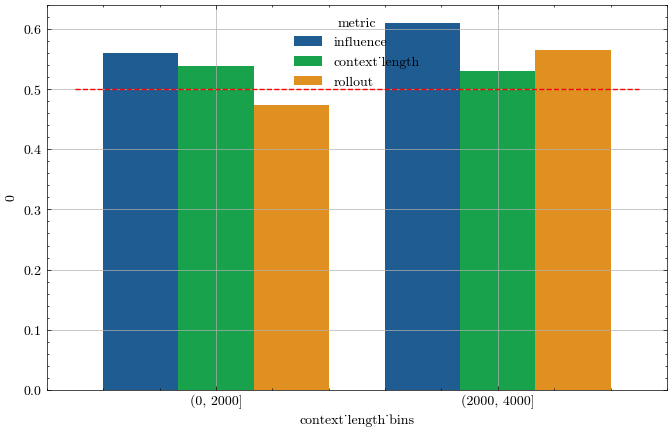

In [31]:
plt.figure(figsize= (8,5))

sns.barplot(
    pd.concat([auc_influence,auc_context_len, auc_rollout]),
    x = 'context_length_bins',
    y = 0,
    hue = 'metric'
)

plt.hlines(0.5, -0.5, 1.5, colors='red', linestyles='dashed')
plt.grid()

In [32]:
influence_corr = {k: [] for k in range(32)}
scores = []

def get_correlations(row):
    influence = row['influence']
    y_pred = row['score']

    for k, v in influence.items():
        last_tokens_influence = v[-5:].mean().item()
        influence_corr[k].append(last_tokens_influence)

    scores.append(y_pred)

scores_df.apply(get_correlations, axis = 1)

0       None
1       None
2       None
3       None
4       None
        ... 
5995    None
5996    None
5997    None
5998    None
5999    None
Length: 6000, dtype: object

In [33]:
for k, v in influence_corr.items():
    influence_corr[k] = pd.Series(v)

df1 = pd.DataFrame(influence_corr)
df1['score'] = scores

In [34]:
scores_df['layer 31'] = scores_df['influence'].apply(lambda x : x[31])
scores_df['layer 0'] = scores_df['influence'].apply(lambda x : x[0])

In [35]:
scores_df['last_layer_influence'] =  scores_df\
    ['layer 31']\
    .apply(lambda x: x[-10:].mean().item())

scores_df['first_layer_influence'] =  scores_df\
    ['layer 0']\
    .apply(lambda x: x[-10:].mean().item())

In [36]:
scores_df['score'] =scores_df['score'].astype(int)

In [37]:
scores_df['last_layer_influence_bins'] = pd.qcut(
    scores_df['last_layer_influence'],
    5
)

scores_df['first_layer_influence_bins'] = pd.qcut(
    scores_df['first_layer_influence'],
    5
)

In [38]:
y_true, proba = scores_df['score'], scores_df['last_layer_influence']

In [39]:
probability_influence_df = scores_df.groupby(['text_idx', 'depth'])\
    [['score', 'last_layer_influence']]\
    .mean()\
    .reset_index()

probability_influence_df

,text_idx,depth,score,last_layer_influence
0,247,0.000000,0.6,0.012672
1,247,24.683399,0.3,0.008949
2,247,49.746719,0.2,0.008865
3,247,74.441630,0.0,0.007988
4,247,100.000000,0.4,0.020142
...,...,...,...,...
593,9948,0.000000,0.6,0.011093
594,9948,24.416404,0.2,0.006229
595,9948,49.526814,0.2,0.003777
596,9948,74.458465,0.1,0.005215


In [40]:
probability_influence_df['last_layer_influence_bins'] = pd.qcut(
    probability_influence_df['last_layer_influence'],
    20
)

In [41]:
probability_influence_df

,text_idx,depth,score,last_layer_influence,last_layer_influence_bins
0,247,0.000000,0.6,0.012672,"(0.0122, 0.0128]"
1,247,24.683399,0.3,0.008949,"(0.00857, 0.0092]"
2,247,49.746719,0.2,0.008865,"(0.00857, 0.0092]"
3,247,74.441630,0.0,0.007988,"(0.00757, 0.00808]"
4,247,100.000000,0.4,0.020142,"(0.0185, 0.0205]"
...,...,...,...,...,...
593,9948,0.000000,0.6,0.011093,"(0.011, 0.0113]"
594,9948,24.416404,0.2,0.006229,"(0.00588, 0.00655]"
595,9948,49.526814,0.2,0.003777,"(0.002, 0.00588]"
596,9948,74.458465,0.1,0.005215,"(0.002, 0.00588]"


In [42]:
probability_influence_df

,text_idx,depth,score,last_layer_influence,last_layer_influence_bins
0,247,0.000000,0.6,0.012672,"(0.0122, 0.0128]"
1,247,24.683399,0.3,0.008949,"(0.00857, 0.0092]"
2,247,49.746719,0.2,0.008865,"(0.00857, 0.0092]"
3,247,74.441630,0.0,0.007988,"(0.00757, 0.00808]"
4,247,100.000000,0.4,0.020142,"(0.0185, 0.0205]"
...,...,...,...,...,...
593,9948,0.000000,0.6,0.011093,"(0.011, 0.0113]"
594,9948,24.416404,0.2,0.006229,"(0.00588, 0.00655]"
595,9948,49.526814,0.2,0.003777,"(0.002, 0.00588]"
596,9948,74.458465,0.1,0.005215,"(0.002, 0.00588]"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'influence')

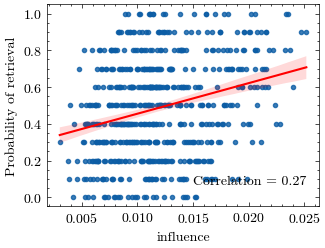

In [43]:
sns.regplot(
    probability_influence_df,
    x = 'last_layer_influence',
    y = 'score',
    marker='.',
    line_kws=dict(color="r")
)

corr = probability_influence_df[['score', 'last_layer_influence']].corr().iloc[0,1]

# plt.xscale("log")
plt.legend(title = f"Correlation = {round(corr,2)}")

plt.ylabel("Probability of retrieval")
plt.xlabel("influence")
# plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


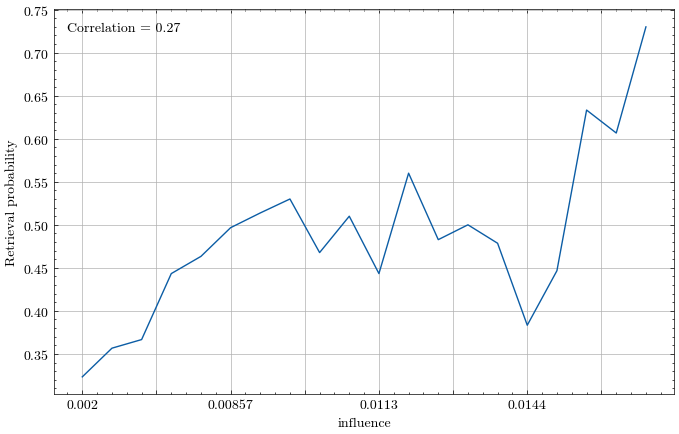

In [44]:
temp = probability_influence_df.groupby('last_layer_influence_bins')\
    .score\
    .mean()

plt.figure(figsize=(8,5))
temp.index = temp.index.map(lambda x: x.left)
temp.plot(label = "")

corr = probability_influence_df[['score', 'last_layer_influence']].corr().iloc[0,1]

# plt.xscale("log")
plt.legend(title = f"Correlation = {round(corr,2)}")
plt.ylabel("Retrieval probability")
plt.xlabel("influence")
plt.grid()

Text(0.5, 0, 'last layer influence')

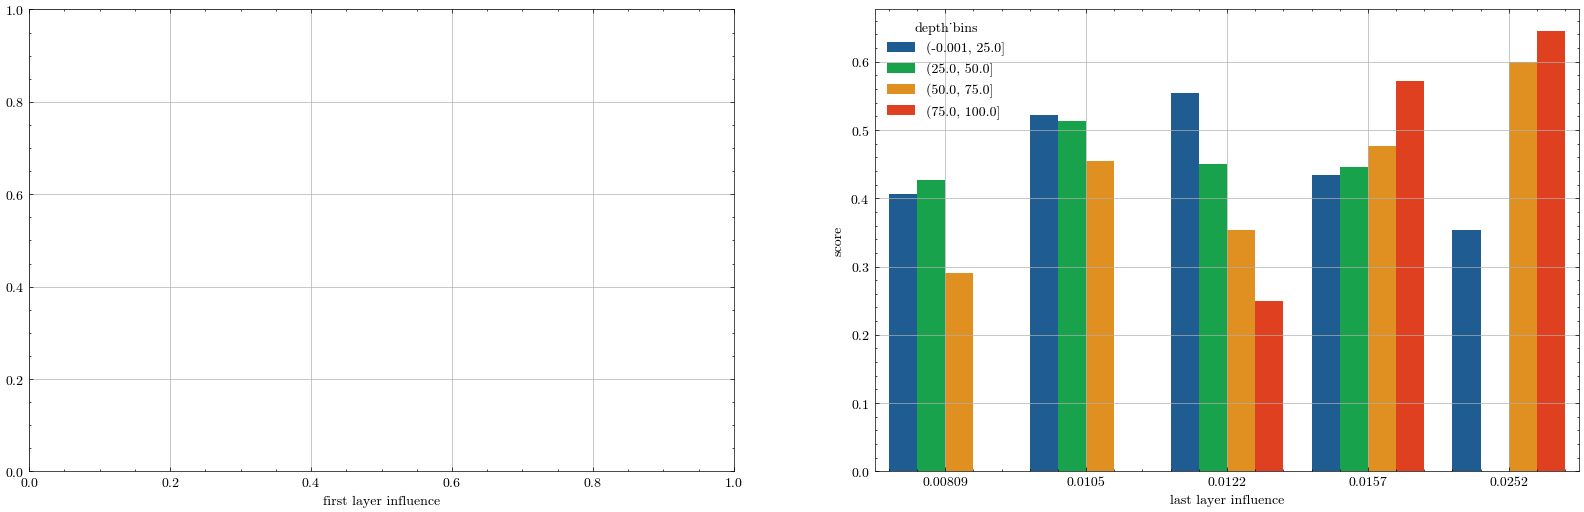

In [45]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))


# first_layer_influence = probability_influence_df.groupby(["first_layer_influence_bins", 'depth_bins'])\
#     .score\
#     .apply(lambda x: np.nan if len(x) < 5 else x.mean())\
#     .reset_index()

# first_layer_influence['first_layer_influence_bins'] = first_layer_influence\
#     ['first_layer_influence_bins']\
#     .apply(lambda x: x.right)


last_layer_influence = scores_df.groupby(["last_layer_influence_bins", 'depth_bins'])\
    .score\
    .apply(lambda x: np.nan if len(x) < 5 else x.mean())\
    .reset_index()

last_layer_influence['last_layer_influence_bins'] = last_layer_influence\
    ['last_layer_influence_bins']\
    .apply(lambda x: x.right)

# sns.barplot(
#     first_layer_influence,
#     x = 'first_layer_influence_bins',
#     y =  'score',
#     hue = 'depth_bins', 
#     ax = ax1
# )

sns.barplot(
    last_layer_influence,
    x = 'last_layer_influence_bins',
    y =  'score',
    hue = 'depth_bins', 
    ax = ax2
)

ax1.grid()
ax2.grid()

ax1.set_xlabel("first layer influence")
ax2.set_xlabel("last layer influence")
# plt.ylim(0,1.1)
# a.plot()
# plt.grid()

<Figure size 1200x500 with 0 Axes>

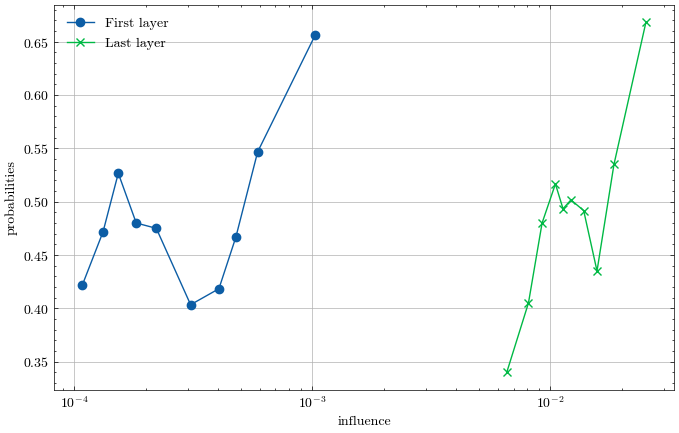

In [46]:
scores_df['influence_last'] = pd.qcut(
    scores_df['last_layer_influence'],
    10
)

scores_df['influence_first'] = pd.qcut(
    scores_df['first_layer_influence'],
    10
)

plt.figure(figsize=(12,5))

a = scores_df.groupby(["influence_first",])\
    .score\
    .apply(lambda x: np.nan if len(x) < 5 else x.mean())

b = scores_df.groupby(["influence_last",])\
    .score\
    .apply(lambda x: np.nan if len(x) < 5 else x.mean())

a.index = a.index.rename("influence")
b.index = b.index.rename("influence")

a.index = np.array(a.index.map(lambda x: x.right))
b.index =  np.array(b.index.map(lambda x: x.right))

plt.figure(figsize=(8, 5))

plt.plot(a.index, a.values, label='First layer', marker='o')
plt.plot(b.index, b.values, label='Last layer', marker='x')


plt.ylabel('probabilities')
plt.xlabel("influence")
plt.xscale("log")

plt.legend()
plt.grid(True)
plt.show()

In [47]:
a

0.000108    0.421667
0.000132    0.471667
0.000153    0.526667
0.000182    0.480000
0.000221    0.475000
0.000308    0.403333
0.000405    0.418333
0.000477    0.466667
0.000589    0.546667
0.001030    0.656667
Name: score, dtype: float64

In [48]:
scores_df['last_layer_influence'] =  scores_df\
    ['layer 31']\
    .apply(lambda x: x[-5:].mean().item())

scores_df['first_layer_influence'] =  scores_df\
    ['layer 0']\
    .apply(lambda x: x[-5:].mean().item())

In [60]:
fig._legend.get_title()

Text(0, 0, 'depth')

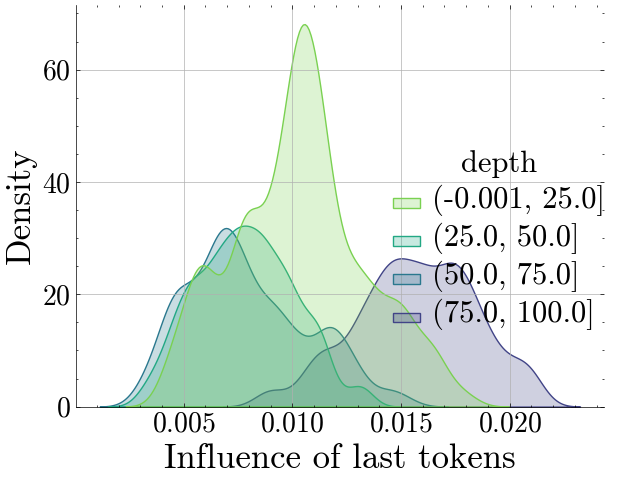

In [70]:
fig = sns.displot(
    scores_df,
    x = 'last_layer_influence',
    hue = 'depth_bins',
    kind = 'kde',
    fill = True,
    palette = 'viridis_r',
)

fig._legend.set_title("depth")

label_fontsize = 25
legend_fontsize = 22
tick_fontsize = 20

plt.setp(fig._legend.get_texts(), fontsize=legend_fontsize) # for legend text
plt.setp(fig._legend.get_title(), fontsize=legend_fontsize)

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)


plt.xlabel("Influence of last tokens", fontsize = label_fontsize)
plt.ylabel("Density", fontsize = label_fontsize)
plt.grid()

plt.tight_layout()

plt.savefig("img/distribution-influence-depth.pdf")

In [92]:
scores_df.groupby("depth_bins")['last_layer_influence'].describe()

,count,mean,std,min,25%,50%,75%,max
depth_bins,,,,,,,,
"(-0.001, 25.0]",2410.0,0.010323,0.003006,0.004230,0.008102,0.010330,0.011955,0.018066
"(25.0, 50.0]",1190.0,0.007847,0.002233,0.003134,0.006172,0.007812,0.009468,0.013367
"(50.0, 75.0]",1200.0,0.007928,0.002766,0.003145,0.006020,0.007406,0.009768,0.015152
"(75.0, 100.0]",1200.0,0.015680,0.002766,0.008812,0.013908,0.015862,0.017635,0.021225


## Obtaining the AUC and correlation

In [93]:
scores_df

,depth,text_idx,influence,context_length,index_x,needle,new_text,question,text,text_len,...,generated_text,score,layer 31,layer 0,last_layer_influence,first_layer_influence,last_layer_influence_bins,first_layer_influence_bins,influence_last,influence_first
0,0.000000,8263,"{0: [tensor(0., dtype=torch.float16), tensor(0...",2970,8263,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,SAN ANTONIO -- Overtime victories on back-to-b...,1989,...,The best thing to do in San Francisco is eat ...,1,"[tensor(0., dtype=torch.float16), tensor(0., d...","[tensor(0., dtype=torch.float16), tensor(0., d...",0.009041,0.000129,"(0.00809, 0.0105]","(-0.0009207, 0.000132]","(0.00923, 0.0105]","(0.000108, 0.000132]"
1,0.000000,8263,"{0: [tensor(0., dtype=torch.float16), tensor(0...",2970,8263,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,SAN ANTONIO -- Overtime victories on back-to-b...,1989,...,The best thing to do in San Francisco is not ...,0,"[tensor(0., dtype=torch.float16), tensor(0., d...","[tensor(0., dtype=torch.float16), tensor(0., d...",0.009041,0.000129,"(0.00809, 0.0105]","(-0.0009207, 0.000132]","(0.00923, 0.0105]","(0.000108, 0.000132]"
2,0.000000,8263,"{0: [tensor(0., dtype=torch.float16), tensor(0...",2970,8263,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,SAN ANTONIO -- Overtime victories on back-to-b...,1989,...,The best thing to do in San Francisco is eat ...,1,"[tensor(0., dtype=torch.float16), tensor(0., d...","[tensor(0., dtype=torch.float16), tensor(0., d...",0.009041,0.000129,"(0.00809, 0.0105]","(-0.0009207, 0.000132]","(0.00923, 0.0105]","(0.000108, 0.000132]"
3,0.000000,8263,"{0: [tensor(0., dtype=torch.float16), tensor(0...",2970,8263,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,SAN ANTONIO -- Overtime victories on back-to-b...,1989,...,"The best thing to do in San Francisco, accord...",1,"[tensor(0., dtype=torch.float16), tensor(0., d...","[tensor(0., dtype=torch.float16), tensor(0., d...",0.009041,0.000129,"(0.00809, 0.0105]","(-0.0009207, 0.000132]","(0.00923, 0.0105]","(0.000108, 0.000132]"
4,0.000000,8263,"{0: [tensor(0., dtype=torch.float16), tensor(0...",2970,8263,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,SAN ANTONIO -- Overtime victories on back-to-b...,1989,...,"Unfortunately, the prompt provided does not i...",0,"[tensor(0., dtype=torch.float16), tensor(0., d...","[tensor(0., dtype=torch.float16), tensor(0., d...",0.009041,0.000129,"(0.00809, 0.0105]","(-0.0009207, 0.000132]","(0.00923, 0.0105]","(0.000108, 0.000132]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,64.854614,5378,"{0: [tensor(0., dtype=torch.float16), tensor(0...",224,5378,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,Three people from Blount County are facing fel...,125,...,The best thing to do in San Francisco accordi...,1,"[tensor(0., dtype=torch.float16), tensor(0., d...","[tensor(0., dtype=torch.float16), tensor(0., d...",0.013329,0.000756,"(0.0122, 0.0157]","(0.000477, 0.00103]","(0.0138, 0.0157]","(0.000589, 0.00103]"
5996,64.854614,5378,"{0: [tensor(0., dtype=torch.float16), tensor(0...",224,5378,\nThe best thing to do in San Francisco is eat...,\n<question>\nYour objective is to answer the ...,Your objective is to answer the following ques...,Three people from Blount County are facing fel...,125,...,"I apologize, but the article does not provide...",0,"[tensor(0., dtype=torch.

In [94]:
target, predictor = scores_df['score'], scores_df['last_layer_influence']

In [95]:
roc_auc_score(target, predictor)

0.5732409713574098

In [96]:
roc_auc_score(
    target,
    1/scores_df['context_length']
)

0.4860067158868529

In [97]:
target.corr(1/scores_df['context_length'])

-0.03613001777645395

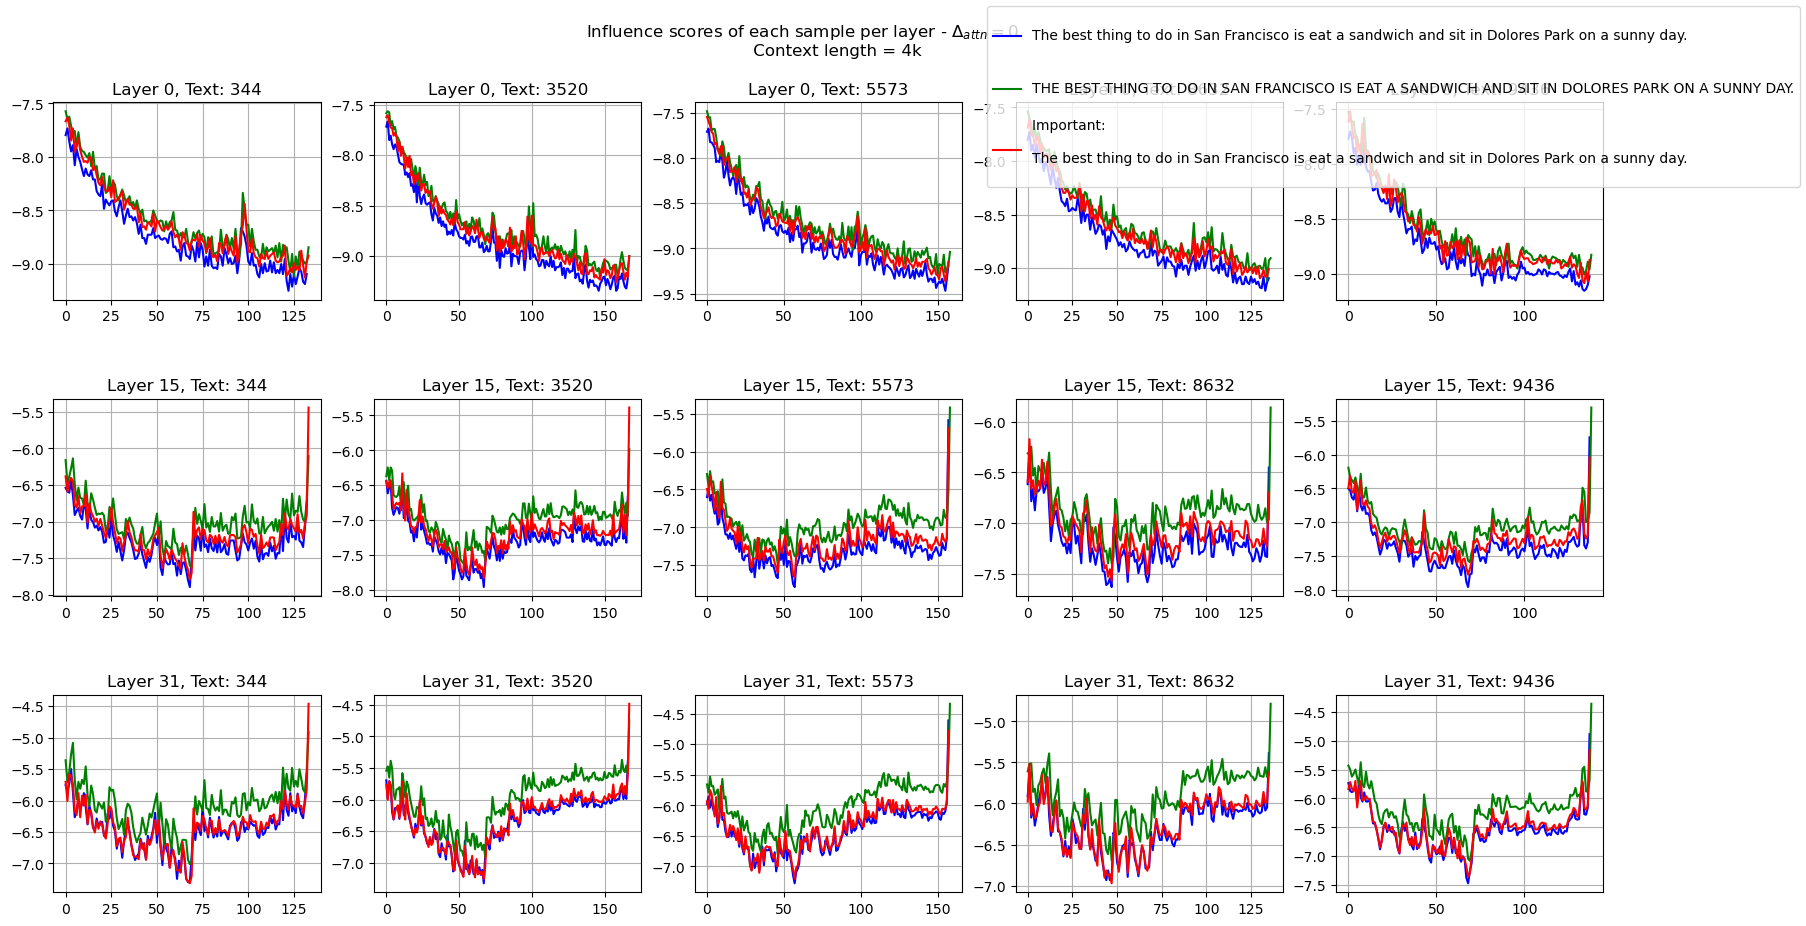

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

text_id_keymap = {k: i for (i,k) in enumerate(sorted(groupby_text_idx.keys()))}
layer_id_keymap = {0:0, 15: 1, 31: 2}


colors = {
    instructions[0]:'b',
    instructions[1]:'g',
    instructions[2]:'r'
}

for text_id, res in pd.DataFrame(groupby_text_idx).T.iterrows():
    for instruction_id in range(len(res)):

        instruction = res.index[instruction_id]
        layers_dict = res.iloc[instruction_id]
        id = text_id_keymap[text_id]

        for layer, influence in layers_dict.items():
            layer_id = layer_id_keymap[layer]

            axes[layer_id][id]\
                .plot(
                    rolling_mean(torch.log(influence), 20)[20:],
                    label = instruction,
                    color = colors[instruction]
                )

            axes[layer_id][id].set_title(f"Layer {layer}, Text: {text_id}")
            axes[layer_id][id].grid(True)
            # axes[layer_id][id].set_ylim([-10, -5])
handles, labels = axes[-1][-1].get_legend_handles_labels()

fig.suptitle(r'''Influence scores of each sample per layer - $\Delta_{attn} = 0$ 
             Context length = 4k''')


fig.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.5)

fig.legend(handles, labels)

In [32]:
gc.collect()
torch.cuda.empty_cache()

In [29]:

chunks = []
samples = df.query(f"context_length > {0} & context_length < {1000}")\
    .sample(5, random_state = 42)
    
chunks.append(samples)

study_df = pd.concat(chunks)\
    .sort_values("context_length", ascending = False)

## Adding the needle
needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"
all_df = []

instructions = [needle, needle.upper(), "Important: \n" + needle]

for instruction in instructions:
    for depth_percent in tqdm(range(0, 125, 25)):

        percent_df = study_df.apply(
            insert_needle, 
            depth_percent = depth_percent, 
            question = question,
            needle = instruction, 
            axis = 1
        )

        all_df.append(percent_df)



samples_df = pd.concat(all_df)\
    .reset_index()

100%|██████████| 5/5 [00:00<00:00, 176.09it/s]


In [33]:
N_LAYERS = 32
influence = Influence()
results_raw = influence(
    base_model,
    tokenizer,
    samples_df.query("depth == 0"),
    0,
    N_LAYERS,
    augmented_layers="none",
    use_values=False,
    instruction_in_text=True,
    instruction_col="needle",
    text_col="new_text"
)

Forward propagation on instruction = Important: 

The best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.
. Index = 14
Finished forward step in 0.25234532356262207 s


100%|██████████| 32/32 [00:01<00:00, 21.19it/s]


In [34]:
groupby_text_idx = {}
for (text_idx, instruction) in results_raw.keys():
    if not text_idx in groupby_text_idx:
        groupby_text_idx[text_idx] = {}

    if not instruction in groupby_text_idx[text_idx]:
        groupby_text_idx[text_idx][instruction] = {}

    for layer in [0, 15, 31]:
        groupby_text_idx[text_idx][instruction][layer] = results_raw\
            [(text_idx, instruction)]\
            ['influences']\
            [layer]

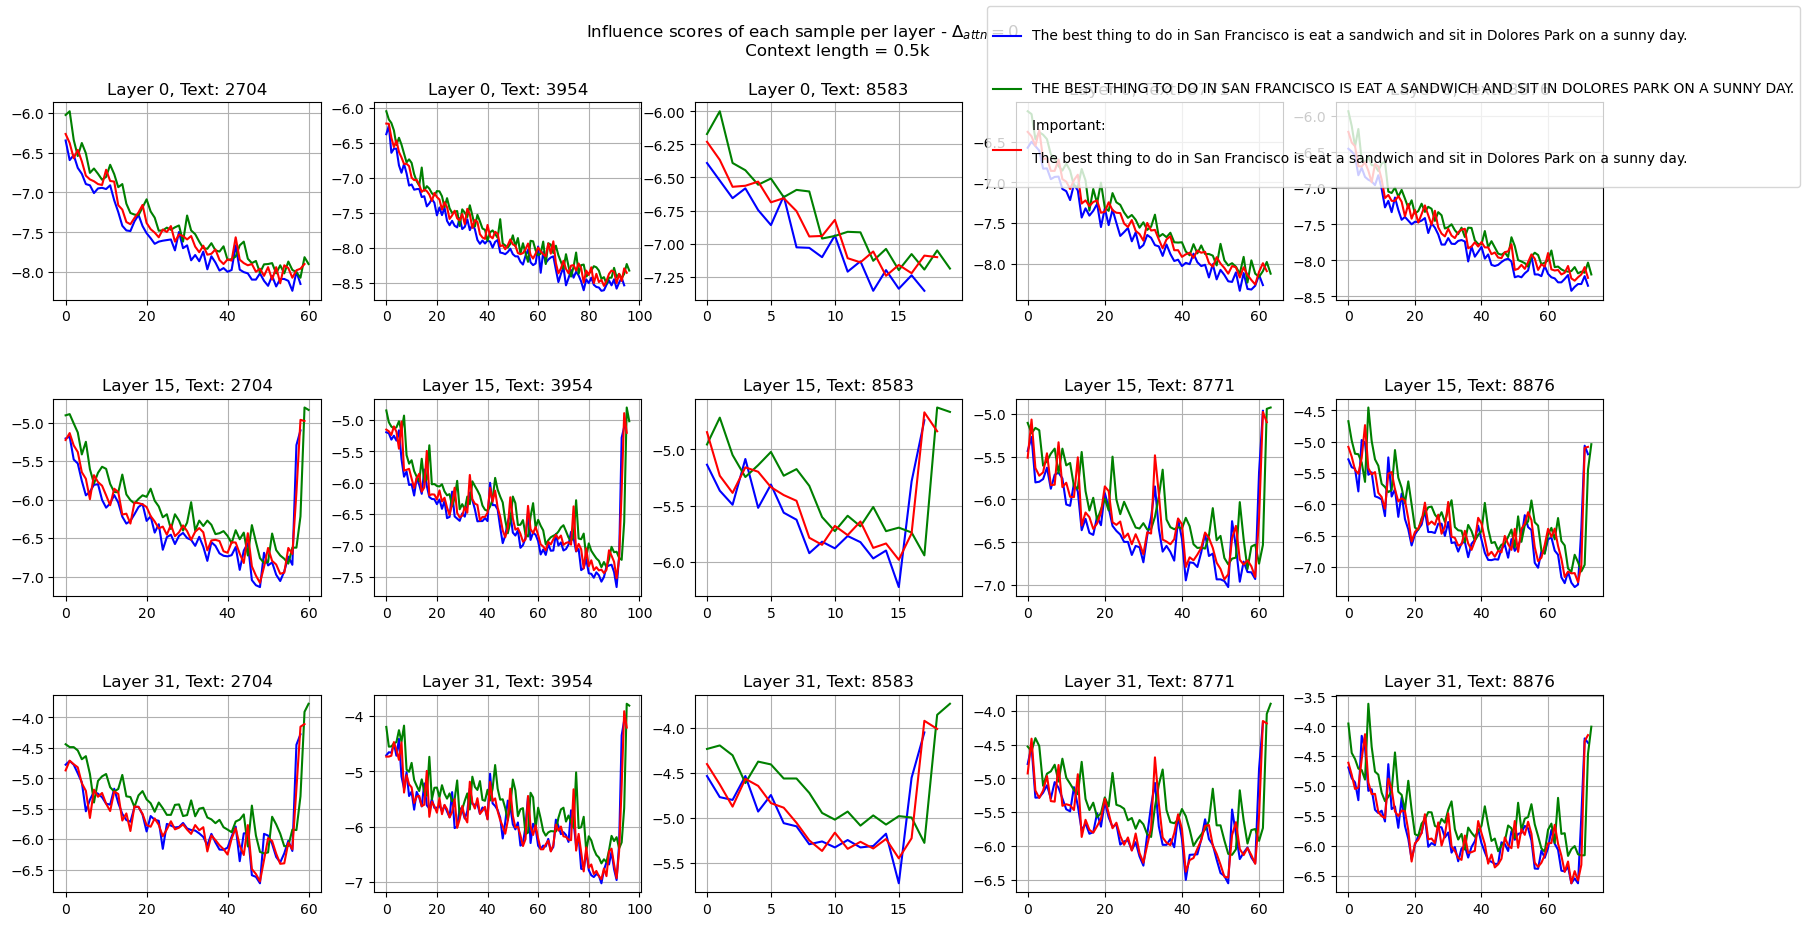

: 

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

text_id_keymap = {k: i for (i,k) in enumerate(sorted(groupby_text_idx.keys()))}
layer_id_keymap = {0:0, 15: 1, 31: 2}


colors = {
    instructions[0]:'b',
    instructions[1]:'g',
    instructions[2]:'r'
}

for text_id, res in pd.DataFrame(groupby_text_idx).T.iterrows():
    for instruction_id in range(len(res)):

        instruction = res.index[instruction_id]
        layers_dict = res.iloc[instruction_id]
        id = text_id_keymap[text_id]

        for layer, influence in layers_dict.items():
            layer_id = layer_id_keymap[layer]

            axes[layer_id][id]\
                .plot(
                    rolling_mean(torch.log(influence), 10)[10:],
                    label = instruction,
                    color = colors[instruction]
                )

            axes[layer_id][id].set_title(f"Layer {layer}, Text: {text_id}")
            axes[layer_id][id].grid(True)
            # axes[layer_id][id].set_ylim([-10, -5])
handles, labels = axes[-1][-1].get_legend_handles_labels()

fig.suptitle(r'''Influence scores of each sample per layer - $\Delta_{attn} = 0$ 
             Context length = 0.5k''')


fig.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.5)

fig.legend(handles, labels)

## Computing the influence of the question

In [5]:
needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"

In [6]:
all_df = []

instructions = [question, question.upper(), "Important: \n" + question]

for instruction in instructions:
    for depth_percent in tqdm(range(0, 125, 25)):

        percent_df = study_df.apply(
            insert_needle, 
            depth_percent = depth_percent, 
            question = instruction,
            needle = needle, 
            axis = 1
        )

        all_df.append(percent_df)




  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 184.65it/s]


In [7]:
samples_df = pd.concat(all_df)\
    .reset_index()

In [8]:
N_LAYERS = 32
influence = Influence()
results_raw = influence(
    base_model,
    tokenizer,
    samples_df.query("depth == 0"),
    0,
    N_LAYERS,
    augmented_layers="none",
    use_values=False,
    instruction_in_text=True,
    instruction_col="question",
    text_col="new_text"
)

Forward propagation on instruction = Important: 
What is the best thing to do in San Francisco?. Index = 14
Influence tokens : 11 to 27
Studying influence to 'Important: 
What is the best thing to do in San Francisco?'
Finished forward step in 2.135467529296875 s


100%|██████████| 32/32 [00:14<00:00,  2.26it/s]


In [10]:
groupby_text_idx = {}
for (text_idx, instruction) in results_raw.keys():
    if not text_idx in groupby_text_idx:
        groupby_text_idx[text_idx] = {}

    if not instruction in groupby_text_idx[text_idx]:
        groupby_text_idx[text_idx][instruction] = {}

    for layer in [0, 15, 31]:
        groupby_text_idx[text_idx][instruction][layer] = results_raw\
            [(text_idx, instruction)]\
            ['influences']\
            [layer]

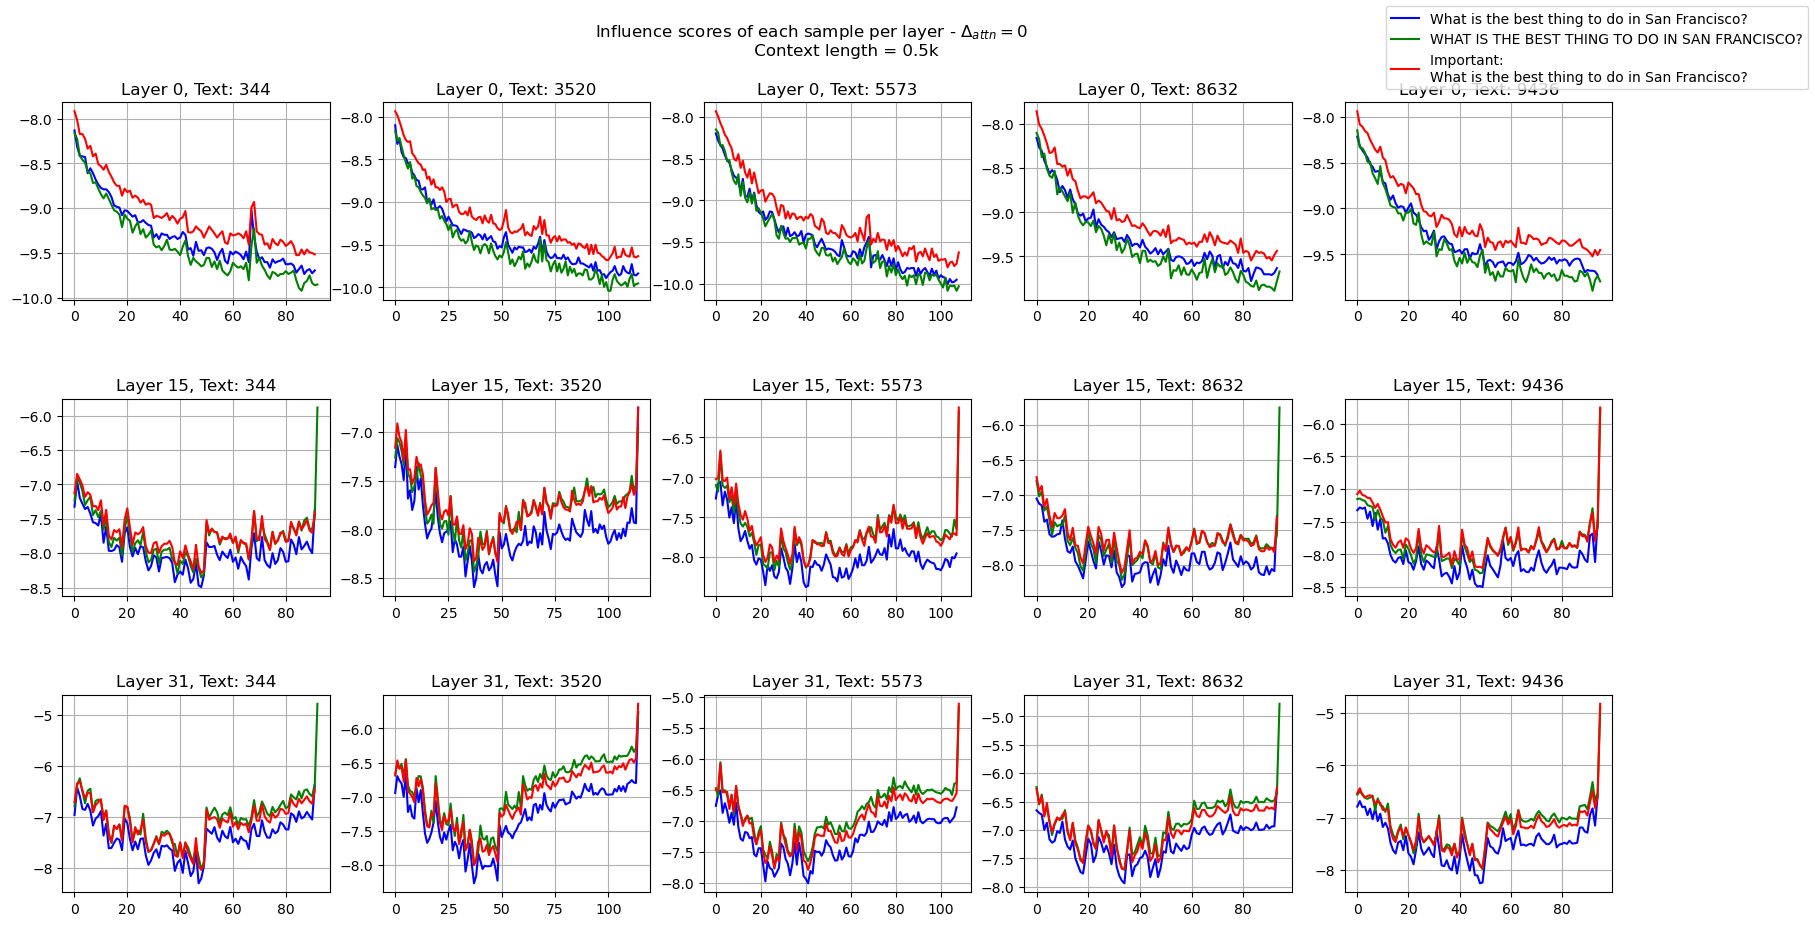

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

text_id_keymap = {k: i for (i,k) in enumerate(sorted(groupby_text_idx.keys()))}
layer_id_keymap = {0:0, 15: 1, 31: 2}


colors = {
    instructions[0]:'b',
    instructions[1]:'g',
    instructions[2]:'r'
}

for text_id, res in pd.DataFrame(groupby_text_idx).T.iterrows():
    for instruction_id in range(len(res)):

        instruction = res.index[instruction_id]
        layers_dict = res.iloc[instruction_id]
        id = text_id_keymap[text_id]

        for layer, influence in layers_dict.items():
            layer_id = layer_id_keymap[layer]

            axes[layer_id][id]\
                .plot(
                    rolling_mean(torch.log(influence), 30)[10:],
                    label = instruction,
                    color = colors[instruction]
                )

            axes[layer_id][id].set_title(f"Layer {layer}, Text: {text_id}")
            axes[layer_id][id].grid(True)
            # axes[layer_id][id].set_ylim([-10, -5])
handles, labels = axes[-1][-1].get_legend_handles_labels()

fig.suptitle(r'''Influence scores of each sample per layer - $\Delta_{attn} = 0$ 
             Context length = 0.5k''')


fig.subplots_adjust(top=0.9)
fig.subplots_adjust(hspace=0.5)

fig.legend(handles, labels)